In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'bright', 'vpedre'])

import os, json
os.chdir('../')
import python.vp_utils as utils

with open('test_out/snapshot_metadata.json') as f:
    metadata = json.load(f)



parameters_sim = utils.parameters_sim

In [9]:
C_ells_XY = np.load('test_out/C_ells_XY.npy', allow_pickle=True).item()
ell_grid = np.load('test_out/ell_grid.npy')

P_curl = np.load('test_out/Pk_curl.npy')
k_curl = np.load('test_out/k_curl.npy')
P_m = np.load('test_out/Pk_m.npy')
k_m = np.load('test_out/k_m.npy')

z=metadata['redshift']

factor = 6*parameters_sim['H0']**2*parameters_sim['Omega_m']*(1+z) 



In [3]:
C_ells_XY.keys()

dict_keys(['Phi', 'kSZ', 'B', 'B_X_kSZ'])

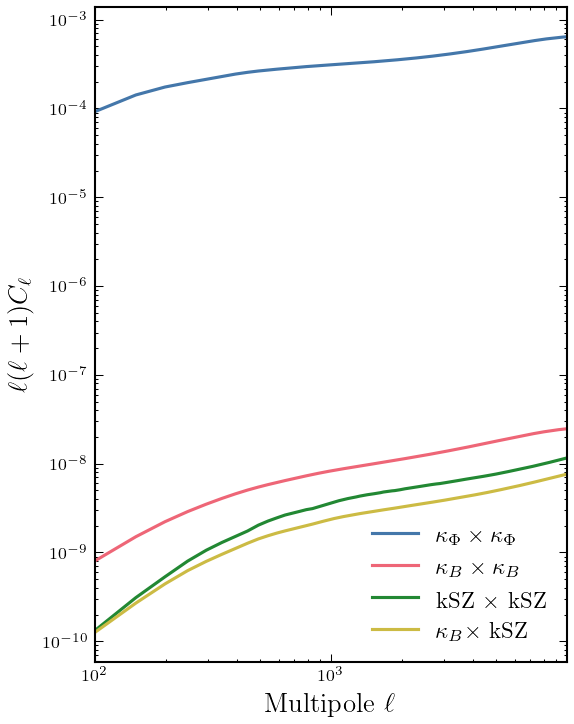

In [4]:
fig, ax = plt.subplots(figsize=(4, 5))

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['Phi'],                 label=r"$\kappa_\Phi \times \kappa_\Phi$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)/factor**2*C_ells_XY['B']  ,       label=r"$\kappa_B \times \kappa_B$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)/factor**2*C_ells_XY['kSZ']    ,   label=r"kSZ $\times$ kSZ")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)/factor**2*C_ells_XY['B_X_kSZ'],   label=r"$\kappa_B \times$ kSZ")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()


Text(0, 0.5, '$P_\\text{m}(k) \\,(\\text{Mpc}/h)^3$')

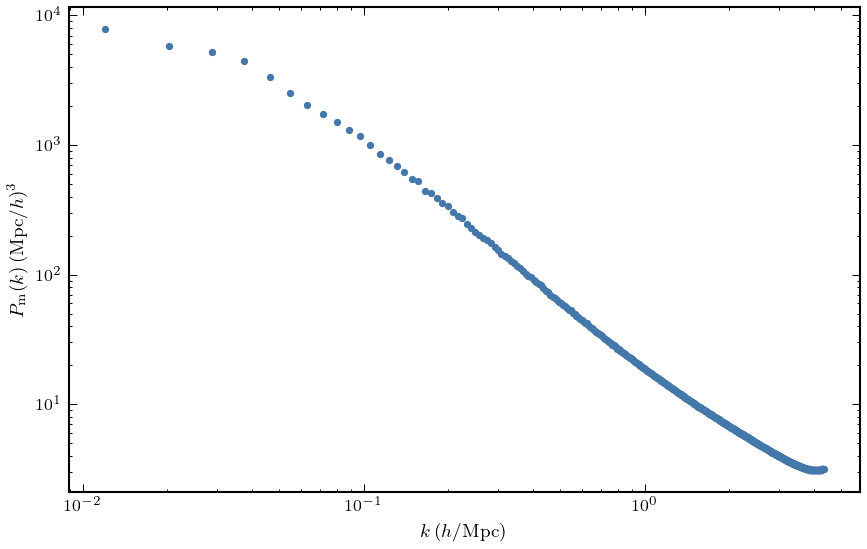

In [5]:
fig, ax = plt.subplots()

ax.loglog(kh_m, Ph_m, '.')

ax.set_xlabel(r'$k \,(h/\text{Mpc})$')
ax.set_ylabel(r'$P_\text{m}(k) \,(\text{Mpc}/h)^3$')

In [10]:
Pk_B = Pk_curl*factor**2 / k_curl**6 

Delta_B = Pk_B * k_curl**3 / (2*np.pi**2) / (parameters_sim['c']**6)

Text(0, 0.5, '$\\Delta_\\text{B}(k)$')

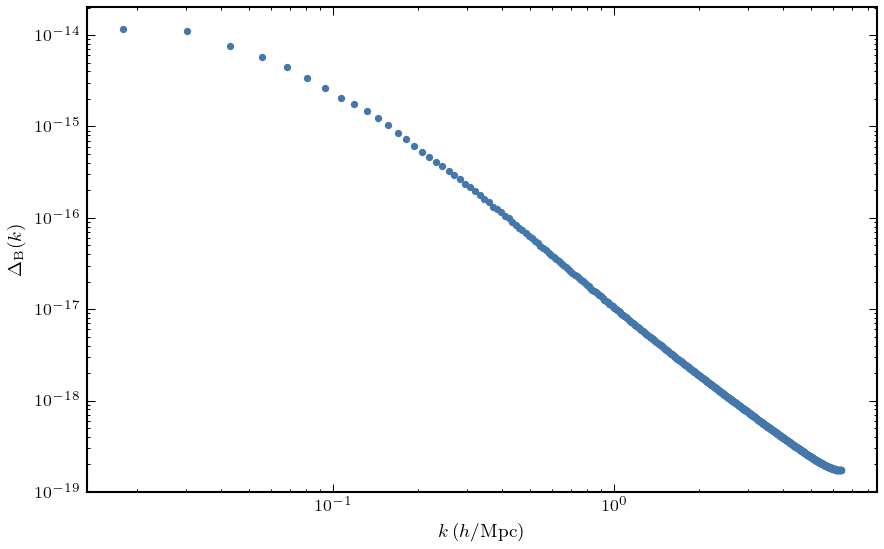

In [13]:
fig, ax = plt.subplots()

ax.loglog(k_curl/h, Delta_B, '.')
ax.set_xlabel(r'$k \,(h/\text{Mpc})$')
ax.set_ylabel(r'$\Delta_\text{B}(k)$')